In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
file_path = "../data/lulesh_summary.csv"

df = pd.read_csv(
    file_path,
    delimiter=",",
    encoding="utf-8",
    header=0
)

In [4]:
df.head()

,nodes,taskspernode,threadspertask,step,balance,cpufreq,slurm_job_id,tpe,tlb,tce,tse,tte,tmpe,tmlb,tmce,tmse,tmte,tope,tolb,toce,tose,tote,epe,elb,ece,ese,ete,empe,emlb,emce,emse,emte,eope,eolb,eoce,eose,eote,total_time
0,1,1,96,1,0,1000000,61141388,0.401,0.855,0.469,0.517,0.907,0.937,1.0,0.937,1.0,0.937,0.428,0.855,0.500,0.517,0.967,0.084,1.703,0.049,1.990,0.025,0.327,1.0,0.327,1.0,0.327,0.256,1.703,0.150,1.990,0.075,22.940
1,1,1,96,1,0,1500000,61141393,0.401,0.916,0.437,0.480,0.911,0.934,1.0,0.934,1.0,0.934,0.429,0.916,0.468,0.480,0.976,0.084,1.222,0.068,2.720,0.025,0.342,1.0,0.342,1.0,0.342,0.245,1.222,0.200,2.720,0.074,18.794
2,1,1,96,1,0,2000000,61141398,0.355,0.823,0.432,0.471,0.917,0.944,1.0,0.944,1.0,0.944,0.376,0.823,0.457,0.471,0.971,0.078,1.328,0.059,0.688,0.086,0.680,1.0,0.680,1.0,0.680,0.115,1.328,0.087,0.688,0.126,18.274
3,1,1,96,1,0,2500000,61141399,0.382,0.911,0.420,0.526,0.798,0.808,1.0,0.808,1.0,0.808,0.473,0.911,0.520,0.526,0.988,0.012,0.973,0.012,0.976,0.013,0.080,1.0,0.080,1.0,0.080,0.150,0.973,0.154,0.976,0.158,7.963
4,1,1,96,1,0,3000000,61141400,0.337,0.900,0.375,0.531,0.706,0.713,1.0,0.713,1.0,0.713,0.473,0.900,0.525,0.531,0.989,0.013,1.636,0.008,0.719,0.011,0.050,1.0,0.050,1.0,0.050,0.254,1.636,0.156,0.719,0.216,7.994


In [5]:
df.shape

(448, 38)

In [6]:
df = df[(df["step"] < 15) & (df["taskspernode"] != 1)]

In [7]:
df.shape

(252, 38)

In [8]:
def values_by_cpufreq(dframe, column):
    vals = []
    for f in cpufreqs:
        row = dframe[dframe["cpufreq"] == f]
        if len(row) == 0:
            vals.append(np.nan)
        else:
            vals.append(row.iloc[0][column])
    return np.array(vals, dtype=float)

[1, 5, 10]
[1, 5, 10]
[1, 5, 10]


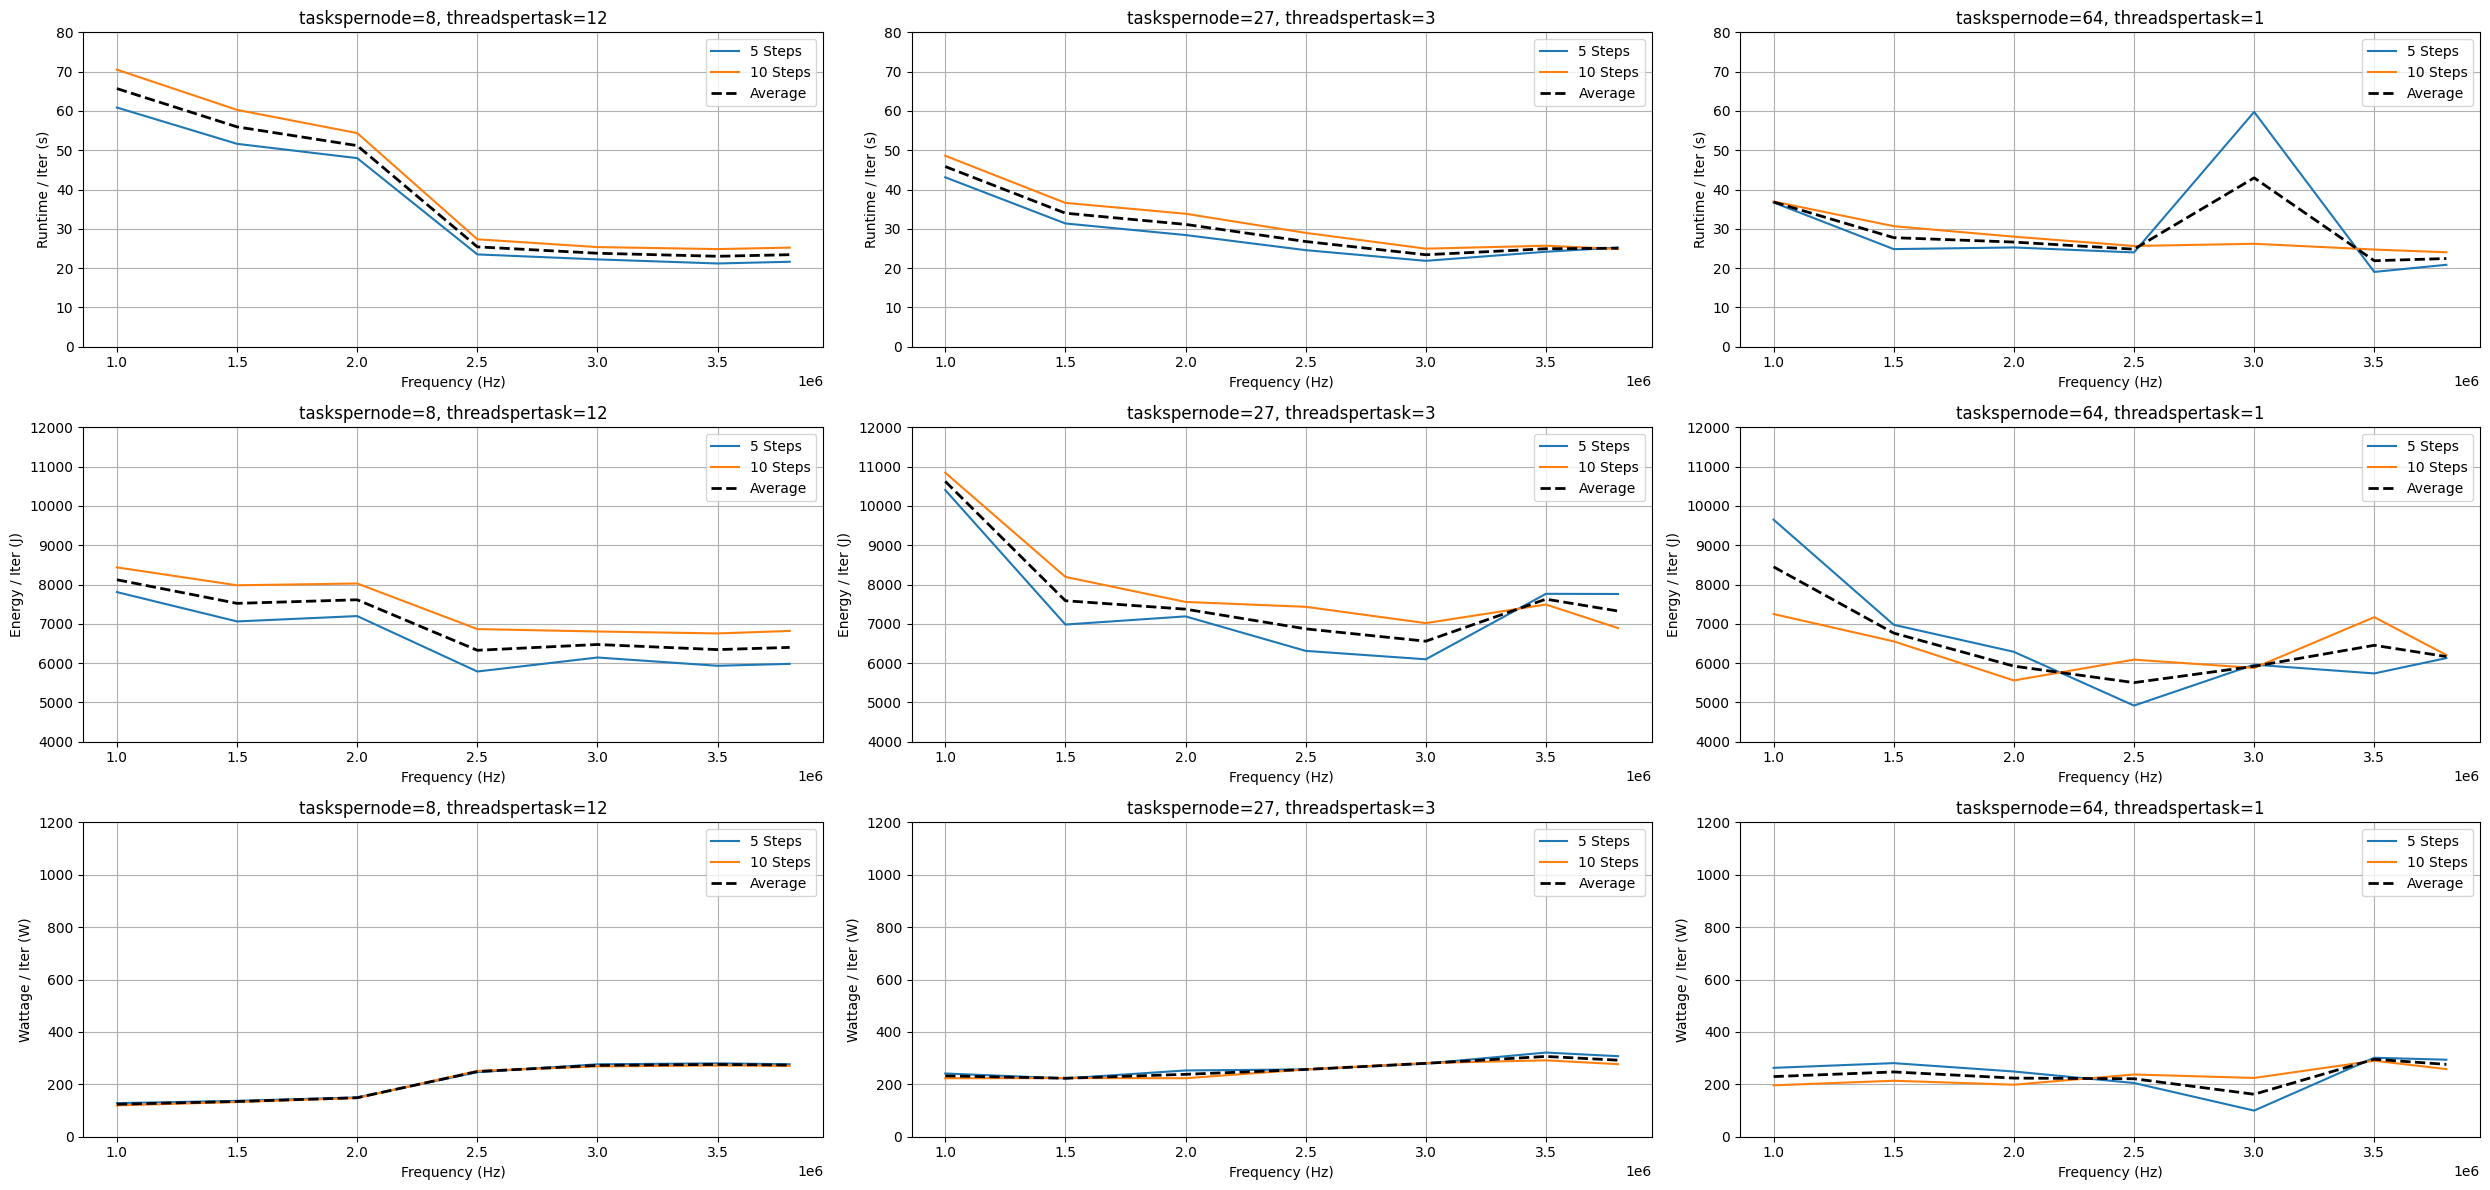

[SAVED] ../results/lulesh_cpufreq_time_energy_wattage_0_balance.png
[1, 5, 10]
[1, 5, 10]
[1, 5, 10]


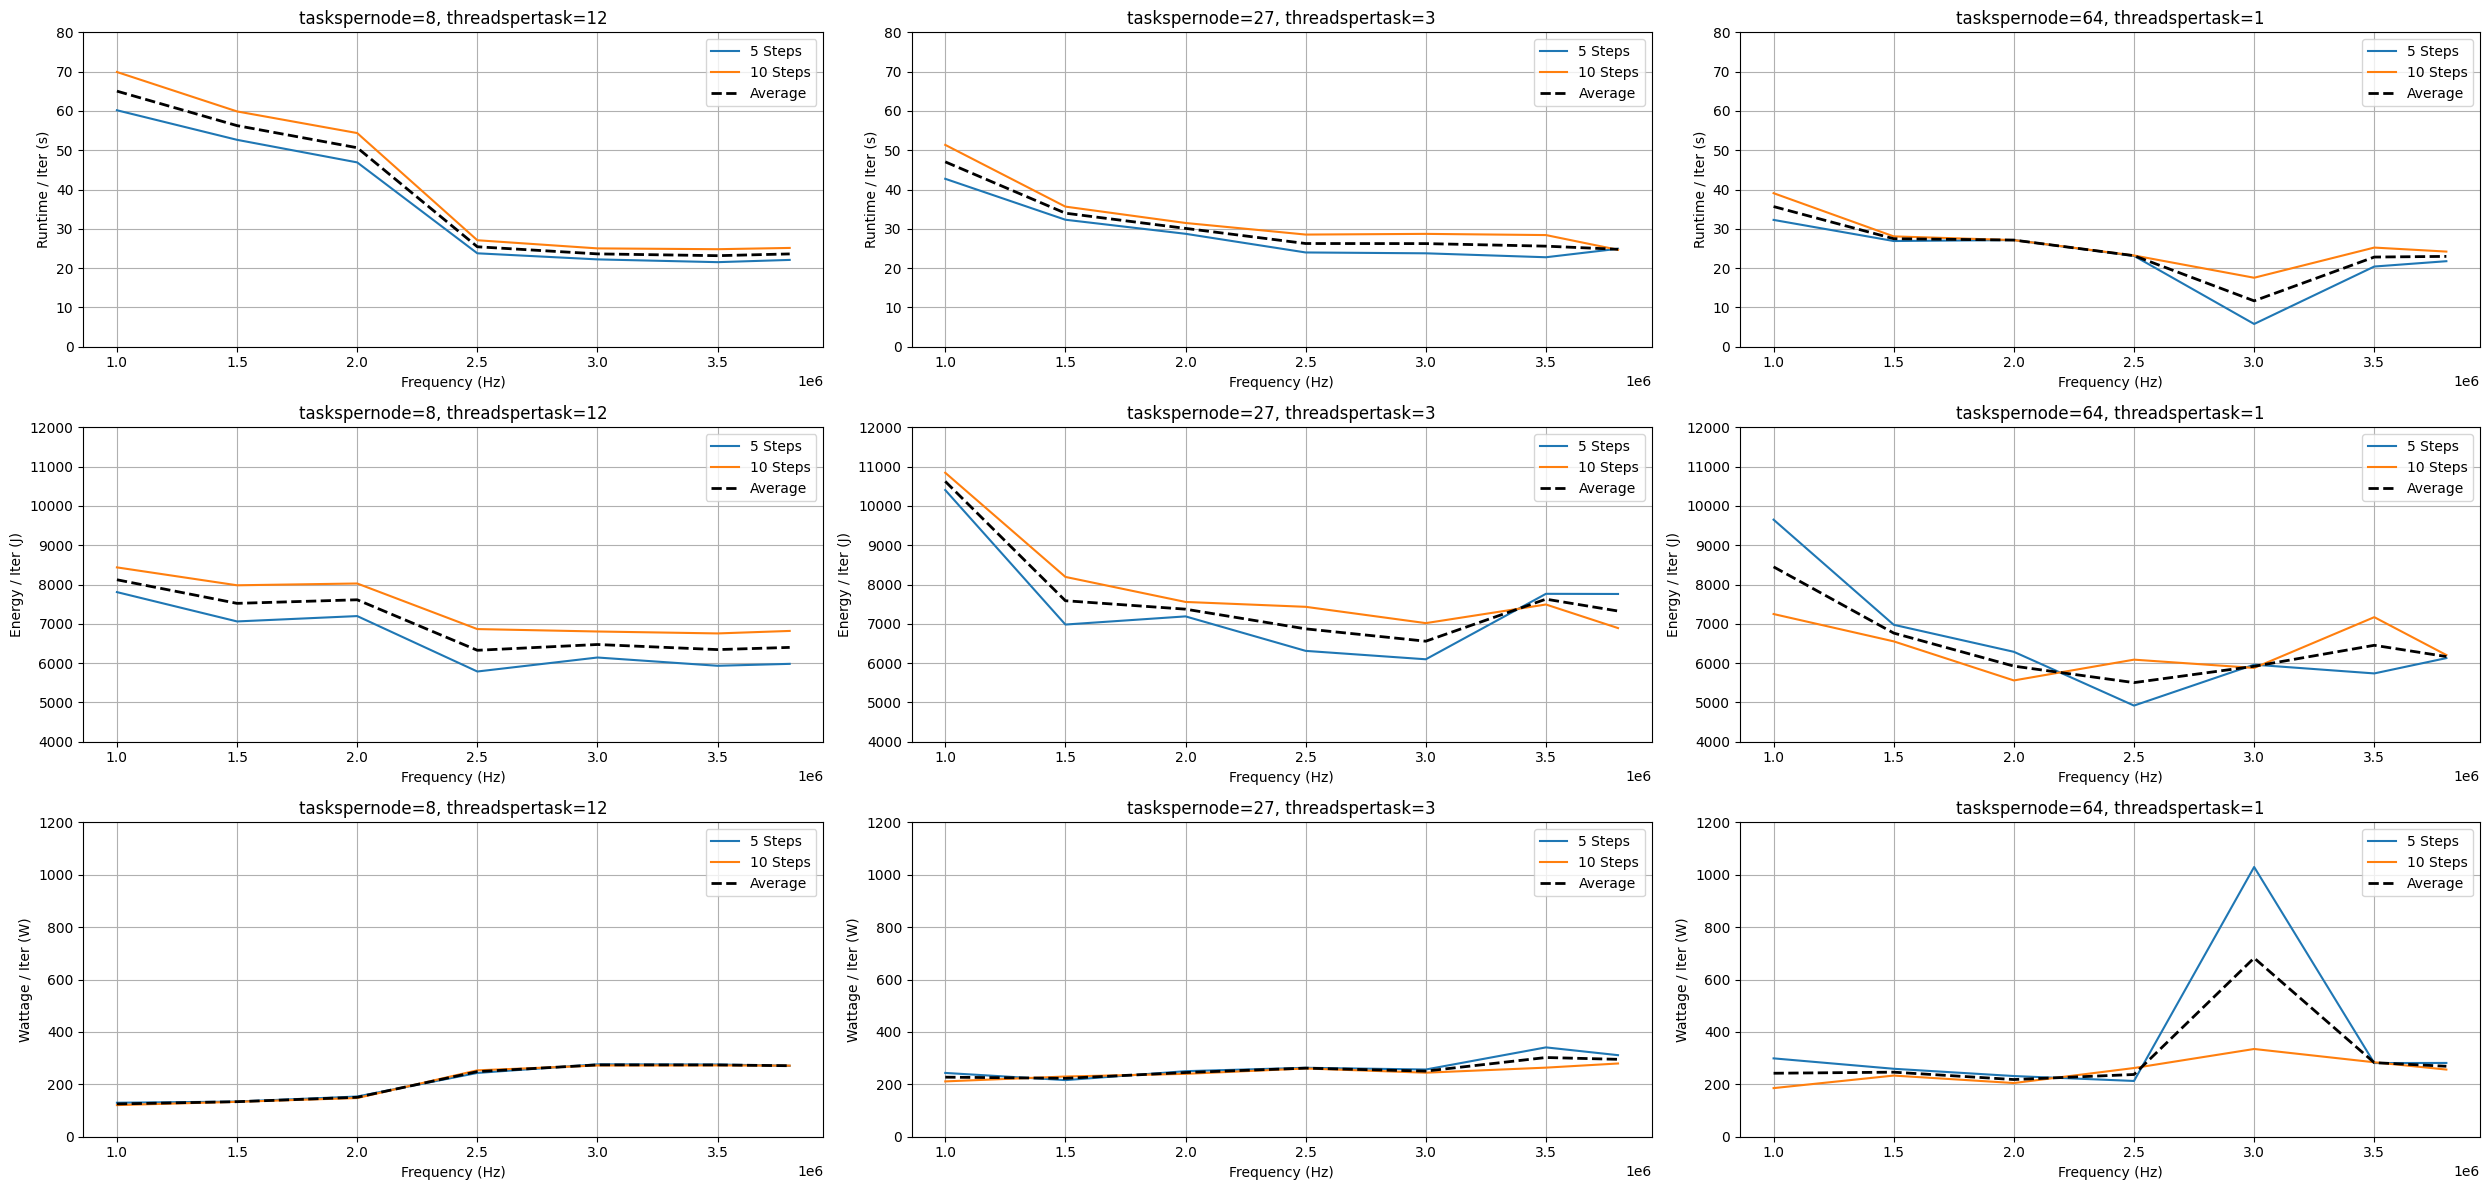

[SAVED] ../results/lulesh_cpufreq_time_energy_wattage_1_balance.png
[1, 5, 10]
[1, 5, 10]
[1, 5, 10]


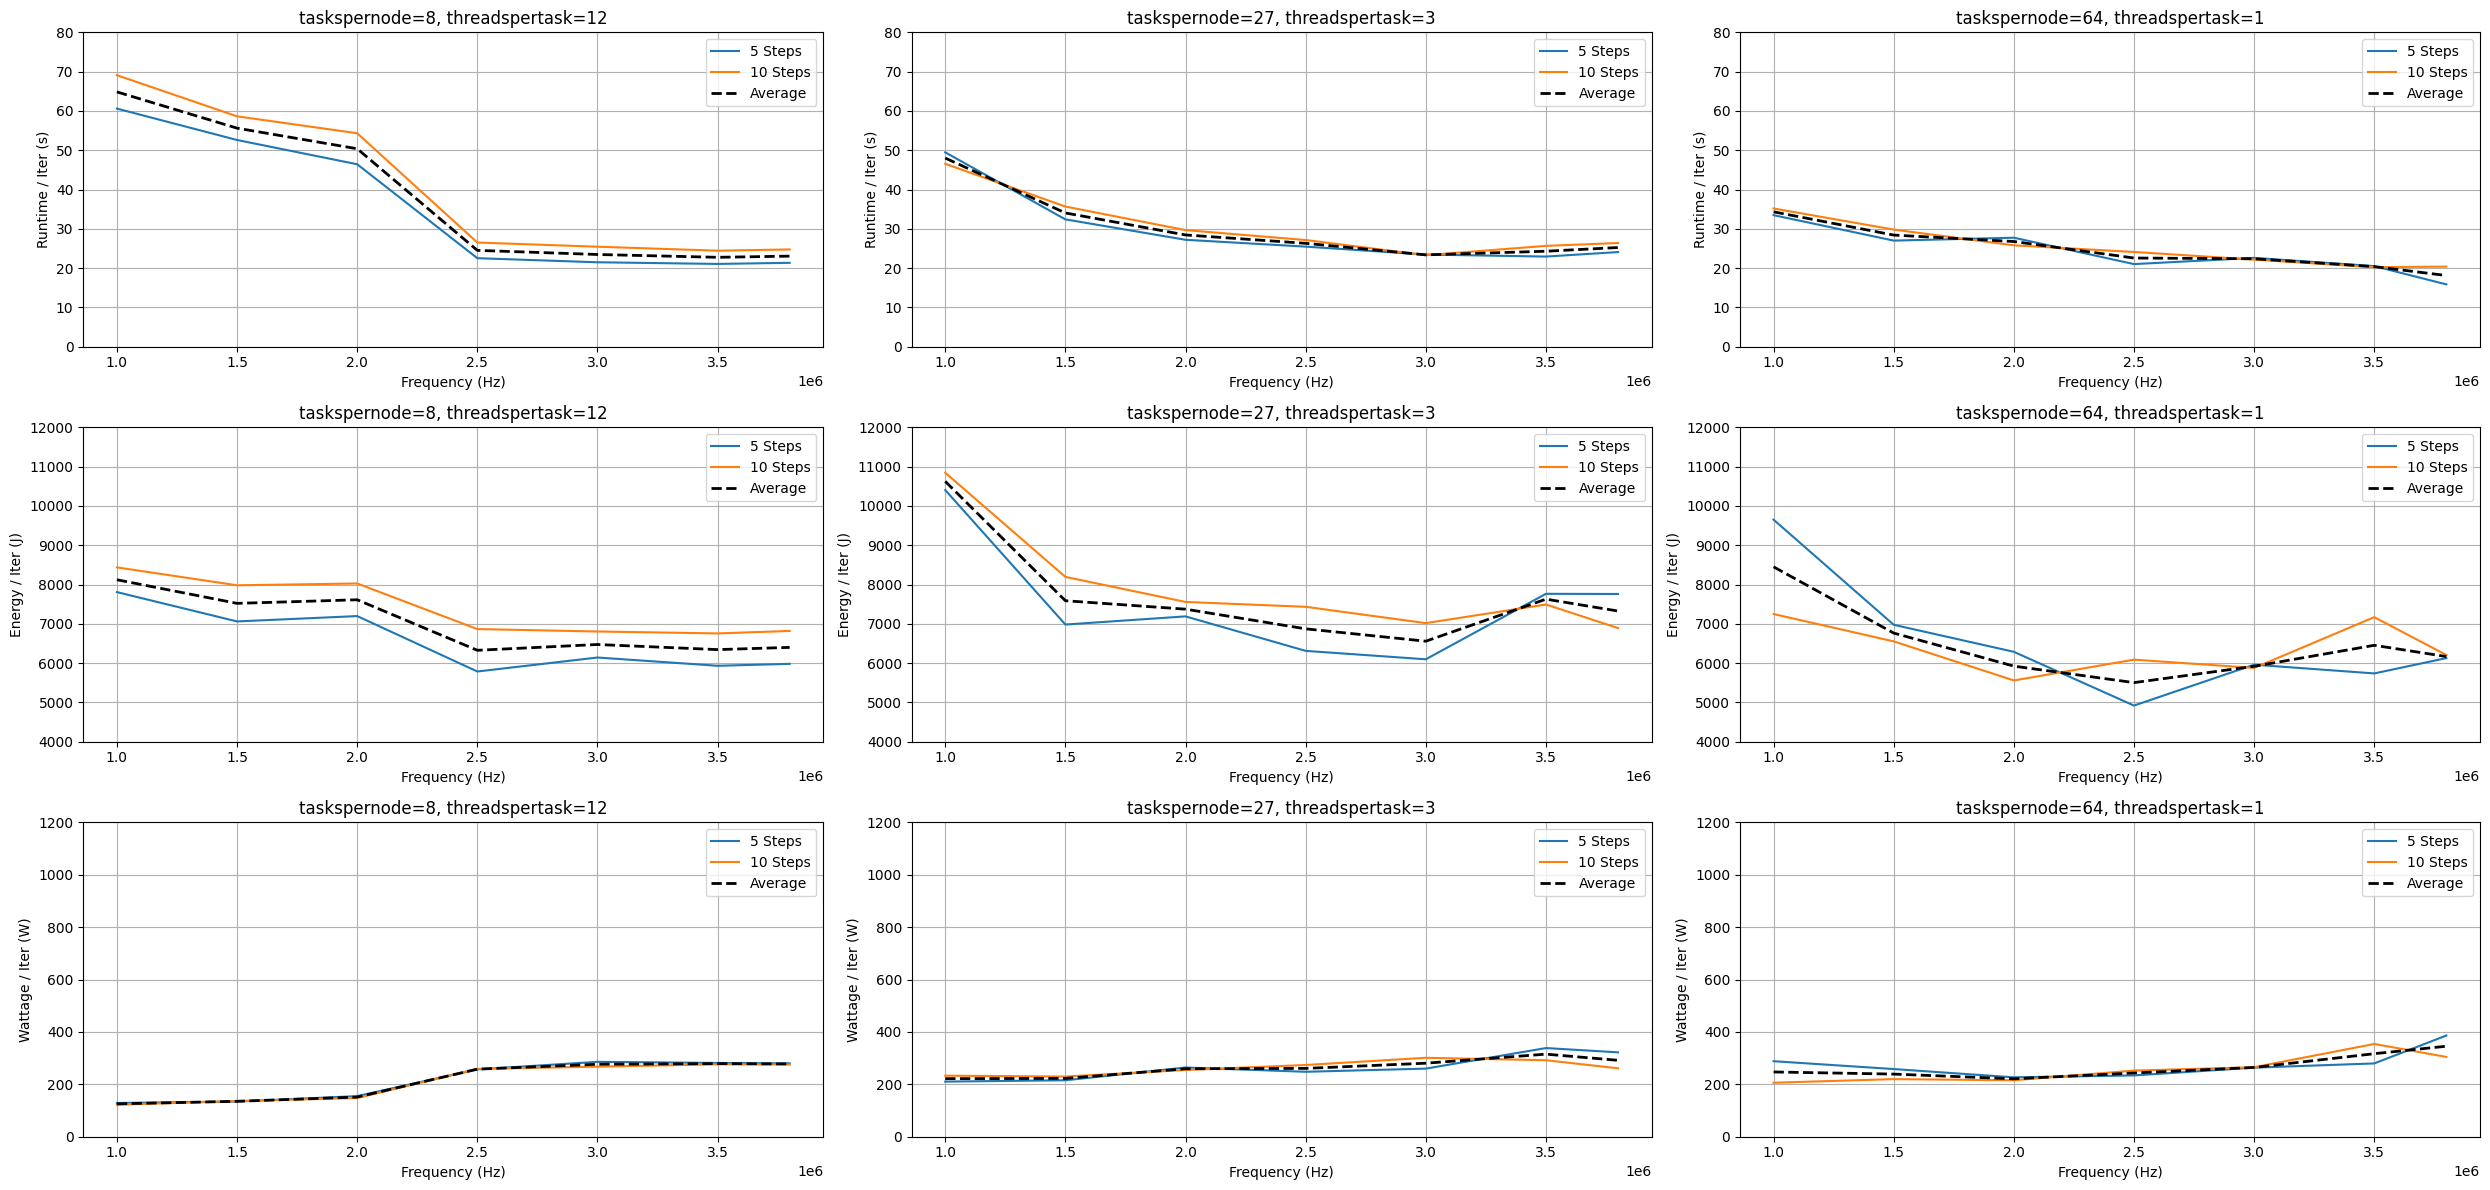

[SAVED] ../results/lulesh_cpufreq_time_energy_wattage_2_balance.png
[1, 5, 10]
[1, 5, 10]
[1, 5, 10]


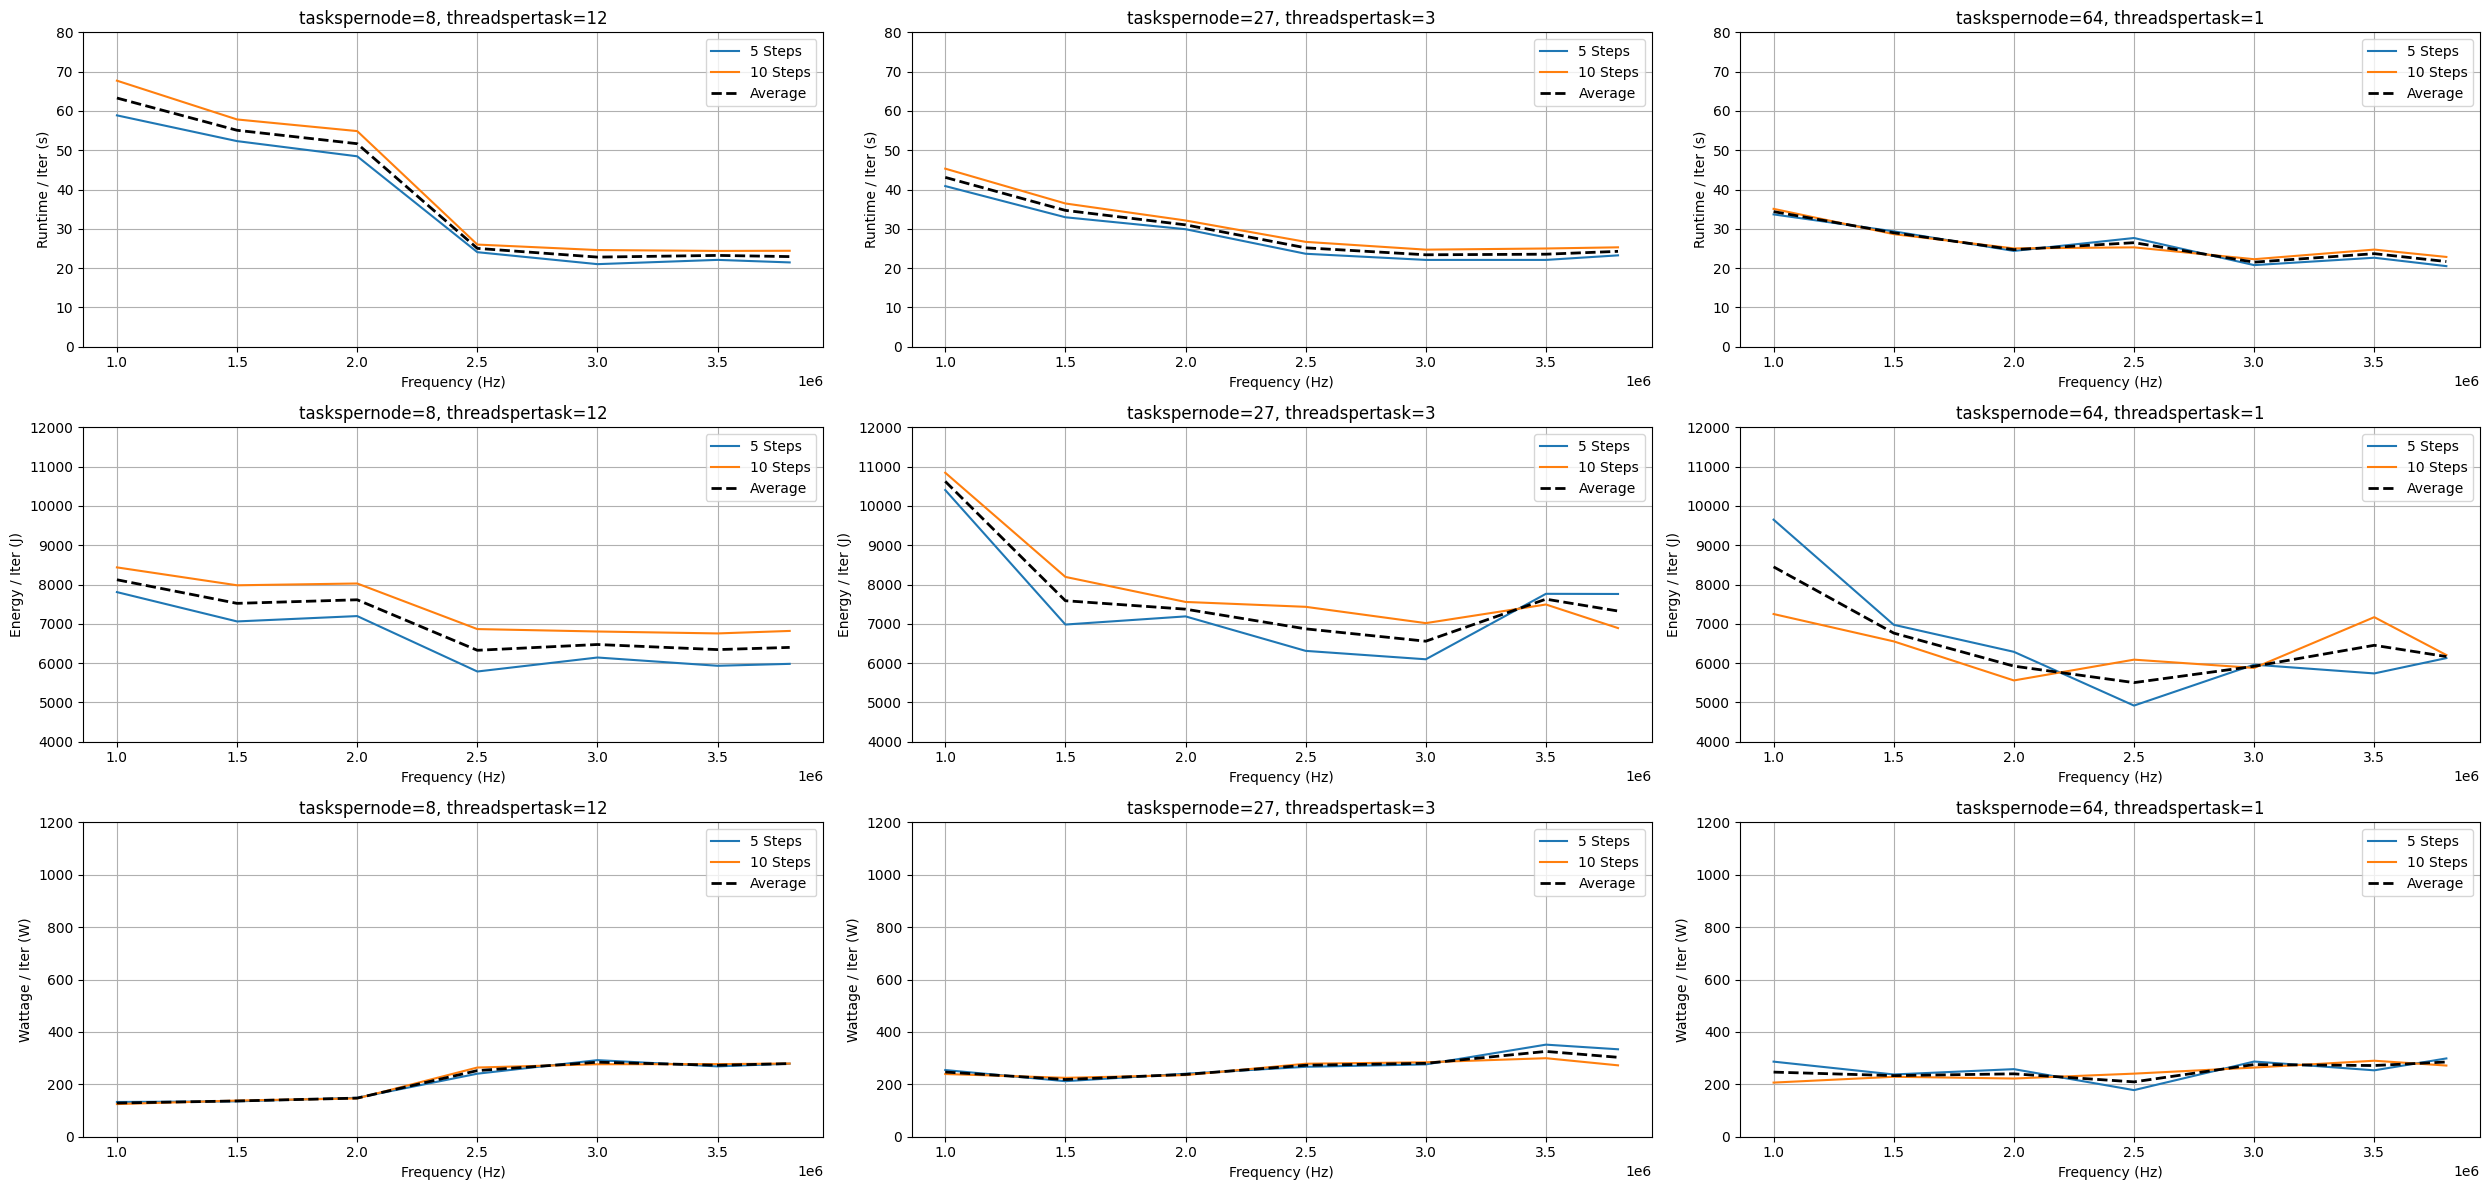

[SAVED] ../results/lulesh_cpufreq_time_energy_wattage_3_balance.png


In [9]:
ncols = 3
avg_steps = [5, 10]

for balance in df["balance"].unique():
    tasks = sorted(set(df["taskspernode"].unique()).union(set(df["taskspernode"].unique())))
    steps = sorted(df["step"].unique())

    fig, axs = plt.subplots(3, ncols, figsize=(25, 12), squeeze=False)

    for t_idx, task in enumerate(tasks):
        col = t_idx % ncols

        cpufreqs = sorted(df.loc[df["taskspernode"] == task, "cpufreq"].unique())
        if len(cpufreqs) == 0:
            cpufreqs = sorted(df.loc[df["taskspernode"] == task, "cpufreq"].unique())
        if len(cpufreqs) == 0:
            print(f"[WARN] No cpufreqs found for task={task}, skipping")
            continue

        base_runtime_df = df[(df["taskspernode"] == task) & (df["step"] == 1) & (df["balance"] == balance)]
        base_runtime = values_by_cpufreq(base_runtime_df, "total_time")

        base_energy = []
        for f in cpufreqs:
            path = f"../data/lulesh_reports/{task}_ranks_{96 // task}_threads_{f}_hz_1_steps_{0}_balance.csv"
            if os.path.exists(path):
                single = pd.read_csv(path)
                base_energy.append(single["total_energy"].max())
            else:
                base_energy.append(np.nan)
        base_energy = np.array(base_energy, dtype=float)

        if np.isnan(base_runtime).all():
            print(f"[WARN] base_runtime all NaN for task={task}, balance={balance} -> skip runtime/derived plots for this task")
        if np.isnan(base_energy).all():
            print(f"[WARN] base_energy all NaN for task={task}, balance={balance} -> skip energy/derived plots for this task")

        runtime_store = {}
        energy_store = {}

        for step in steps:
            if step == 1:
                continue

            rt_df = df[(df["taskspernode"] == task) & (df["step"] == step) & (df["balance"] == balance)]
            total_time = values_by_cpufreq(rt_df, "total_time")

            if np.isnan(base_runtime).any() or np.isnan(total_time).any():
                print(f"[INFO] skipping runtime step={step} for task={task} (missing data or mismatch)")
                continue

            runtime_per_iter = (total_time - base_runtime) / (step - 1)
            runtime_store[(task, step)] = runtime_per_iter

            total_energy_list = []
            missing_csv = False
            for f in cpufreqs:
                path = f"../data/lulesh_reports/{task}_ranks_{96 // task}_threads_{f}_hz_{step}_steps_{0}_balance.csv"
                if os.path.exists(path):
                    single_run_df = pd.read_csv(path)
                    total_energy_list.append(single_run_df["total_energy"].max())
                else:
                    total_energy_list.append(np.nan)
                    missing_csv = True

            total_energy_arr = np.array(total_energy_list, dtype=float)
            if np.isnan(total_energy_arr).any() or np.isnan(base_energy).any():
                print(f"[INFO] skipping energy step={step} for task={task} (missing csv or base energy)")
                continue

            energy_per_iter = (total_energy_arr - base_energy) / (step - 1)
            energy_store[(task, step)] = energy_per_iter

            if (task, step) in runtime_store and (task, step) in energy_store:
                axs[0, col].plot(cpufreqs, runtime_per_iter, label=f"{step} Steps")
                axs[1, col].plot(cpufreqs, energy_per_iter, label=f"{step} Steps")

        rt_avgs = []
        for s in avg_steps:
            key = (task, s)
            if key in runtime_store:
                rt_avgs.append(runtime_store[key])
        if len(rt_avgs) == len(avg_steps):
            rt_avg = np.mean(np.vstack(rt_avgs), axis=0)
            axs[0, col].plot(cpufreqs, rt_avg, linestyle='--', linewidth=2, label="Average", color='k')
        else:
            print(f"[INFO] cannot plot runtime avg for task={task} — found {len(rt_avgs)}/{len(avg_steps)} of required steps")

        en_avgs = []
        for s in avg_steps:
            key = (task, s)
            if key in energy_store:
                en_avgs.append(energy_store[key])
        if len(en_avgs) == len(avg_steps):
            en_avg = np.mean(np.vstack(en_avgs), axis=0)
            axs[1, col].plot(cpufreqs, en_avg, linestyle='--', linewidth=2, label="Average", color='k')
        else:
            print(f"[INFO] cannot plot energy avg for task={task} — found {len(en_avgs)}/{len(avg_steps)} of required steps")

        wattage_store = {}
        for s in steps:
            key = (task, s)
            if key in runtime_store and key in energy_store:
                rt = np.array(runtime_store[key], dtype=float)
                en = np.array(energy_store[key], dtype=float)
                with np.errstate(divide='ignore', invalid='ignore'):
                    watt = np.where(rt > 0, en / rt, np.nan)
                wattage_store[key] = watt
                axs[2, col].plot(cpufreqs, watt, label=f"{s} Steps")

        w_avgs = []
        for s in avg_steps:
            k = (task, s)
            if k in wattage_store:
                w_avgs.append(wattage_store[k])
        if len(w_avgs) == len(avg_steps):
            w_avg = np.mean(np.vstack(w_avgs), axis=0)
            axs[2, col].plot(cpufreqs, w_avg, linestyle='--', linewidth=2, label="Average", color='k')
        else:
            print(f"[INFO] cannot plot wattage avg for task={task} — found {len(w_avgs)}/{len(avg_steps)} of required steps")

        axs[0, col].set_title(f'taskspernode={task}, threadspertask={96//task}')
        axs[0, col].set_xlabel('Frequency (Hz)')
        axs[0, col].set_ylabel('Runtime / Iter (s)')
        axs[0, col].legend()
        axs[0, col].grid(True)
        axs[0, col].set_ylim([0, 80])
        axs[1, col].set_title(f'taskspernode={task}, threadspertask={96//task}')
        axs[1, col].set_xlabel('Frequency (Hz)')
        axs[1, col].set_ylabel('Energy / Iter (J)')
        axs[1, col].legend()
        axs[1, col].grid(True)
        axs[1, col].set_ylim([4000, 12000])
        axs[2, col].set_title(f'taskspernode={task}, threadspertask={96//task}')
        axs[2, col].set_xlabel('Frequency (Hz)')
        axs[2, col].set_ylabel('Wattage / Iter (W)')
        axs[2, col].legend()
        axs[2, col].grid(True)
        axs[2, col].set_ylim([0, 1200])

    plt.tight_layout()
    outpath = f"../results/lulesh_cpufreq_time_energy_wattage_{balance}_balance.png"
    plt.savefig(outpath, dpi=300)
    plt.show()
    print(f"[SAVED] {outpath}")